In [77]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [207]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)

        return e6

In [208]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [209]:
best_cnn_tree_param = np.load("../code/baseline/result/cnn-tree-new-param-1.npy").item()

In [258]:
torch.manual_seed(0)
num_folds = 5
dataset = 1
fold_num = 2
train, a_test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [259]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)

In [260]:
_, t_test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)
t_test_aggregate = t_test[:, 0, :, :].reshape(t_test.shape[0], 1, -1, 24)
a_test_aggregate = a_test[:, 0, :, :].reshape(a_test.shape[0], 1, -1, 24)

In [261]:
num_iterations = best_cnn_tree_param[fold_num]['iters']
lr = best_cnn_tree_param[fold_num]['lr']
ORDER = list(best_cnn_tree_param[fold_num]['order'])
print(lr, num_iterations, ORDER)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

0.01 18000 ['hvac', 'fridge', 'mw', 'dw', 'dr']


In [262]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(t_test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((t_test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [263]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [264]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

t_test_inp = Variable(torch.Tensor(t_test_aggregate), requires_grad=False)
if cuda_av:
    t_test_inp = t_test_inp.cuda()
    
a_test_inp = Variable(torch.Tensor(a_test_aggregate), requires_grad=False)
if cuda_av:
    a_test_inp = a_test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [265]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [266]:
p = 0
# num_iterations = iters
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(num_iterations):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)

    loss.backward()
    optimizer.step()

In [267]:
# for artificial aggregate test
if cuda_av:
    a_test_inp = a_test_inp.cuda()
a_test_params = [a_test_inp, -2]
for i in range(len(ORDER)):
    a_test_params.append(None)
a_test_pr = model(*a_test_params)
a_test_pr = torch.clamp(a_test_pr, min=0.)
a_test_loss = loss_func(a_test_pr, test_out)

# for true aggregate test
if cuda_av:
    t_test_inp = t_test_inp.cuda()
t_test_params = [t_test_inp, -2]
for i in range(len(ORDER)):
    t_test_params.append(None)
t_test_pr = model(*t_test_params)
t_test_pr = torch.clamp(t_test_pr, min=0.)
t_test_loss = loss_func(t_test_pr, test_out)


In [268]:
from sklearn.metrics import mean_absolute_error

a_test_pred = torch.split(a_test_pr, a_test_aggregate.shape[0])
a_test_fold = [None for x in range(len(ORDER))]
if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        a_test_fold[appliance_num] = a_test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        a_test_fold[appliance_num] = a_test_pred[appliance_num].data.numpy().reshape(-1, 24)
        
t_test_pred = torch.split(t_test_pr, t_test_aggregate.shape[0])
t_test_fold = [None for x in range(len(ORDER))]
if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        t_test_fold[appliance_num] = t_test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        t_test_fold[appliance_num] = t_test_pred[appliance_num].data.numpy().reshape(-1, 24)


In [269]:
# store the ground truth

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = t_test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        t_test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

In [270]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

In [271]:
threshold = {'dr': 18.233293339770761, 'dw': 11.704597207156935, 'mw': 1.2877147226060413}

In [272]:
a_test_error = {}
for appliance_num, appliance in enumerate(ORDER):
    if appliance in ['hvac', 'fridge']:
        a_test_error[appliance] = mean_absolute_error(a_test_fold[appliance_num], test_gt_fold[appliance_num])
    else:
        a_test_error[appliance] = onoff_error(a_test_fold[appliance_num], test_gt_fold[appliance_num], threshold[appliance])
    
t_test_error = {}
for appliance_num, appliance in enumerate(ORDER):
    if appliance in ['hvac', 'fridge']:
        t_test_error[appliance] = mean_absolute_error(t_test_fold[appliance_num], test_gt_fold[appliance_num])
    else:
        t_test_error[appliance] = onoff_error(t_test_fold[appliance_num], test_gt_fold[appliance_num], threshold[appliance])
    

In [273]:
a_test_error

{'dr': 103.16534831369779,
 'dw': 212.58497833185709,
 'fridge': 41.919609925853798,
 'hvac': 156.51819603304747,
 'mw': 9.6412786537694188}

In [274]:
t_test_error

{'dr': 215.24471530302475,
 'dw': 212.58497833185709,
 'fridge': 46.11280765480894,
 'hvac': 325.11992149382837,
 'mw': 9.7813813124291169}

In [275]:
error = {}
error['True aggregate test'] = t_test_error
error['Artificial aggregate test'] = a_test_error
pd.DataFrame(error).T

,dr,dw,fridge,hvac,mw
Artificial aggregate test,103.165348,212.584978,41.919610,156.518196,9.641279
True aggregate test,215.244715,212.584978,46.112808,325.119921,9.781381


In [228]:
ORDER

['mw', 'fridge', 'hvac', 'dw', 'dr']

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
cmap = sns.cubehelix_palette(as_cmap=True)

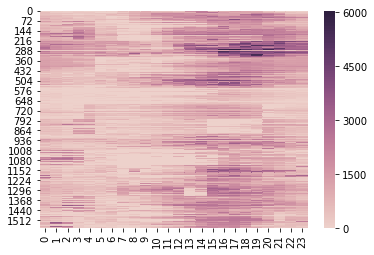

In [230]:
sns.heatmap(t_test_fold[ORDER.index('hvac')], cmap=cmap)

In [231]:
def set_scale(d1, d2, d3):
    max = np.zeros(3)
    max[0] = d1.max()
    max[1] = d2.max()
    max[2] = d3.max()
    
    return max.max()

In [127]:
set_scale(t_test_aggregate[i][0], t_test_fold[ORDER.index(appliance)], a_test_aggregate[i][0], a_test_fold[ORDER.index(appliance)], test_gt_fold[ORDER.index(appliance)])

10279.68359375

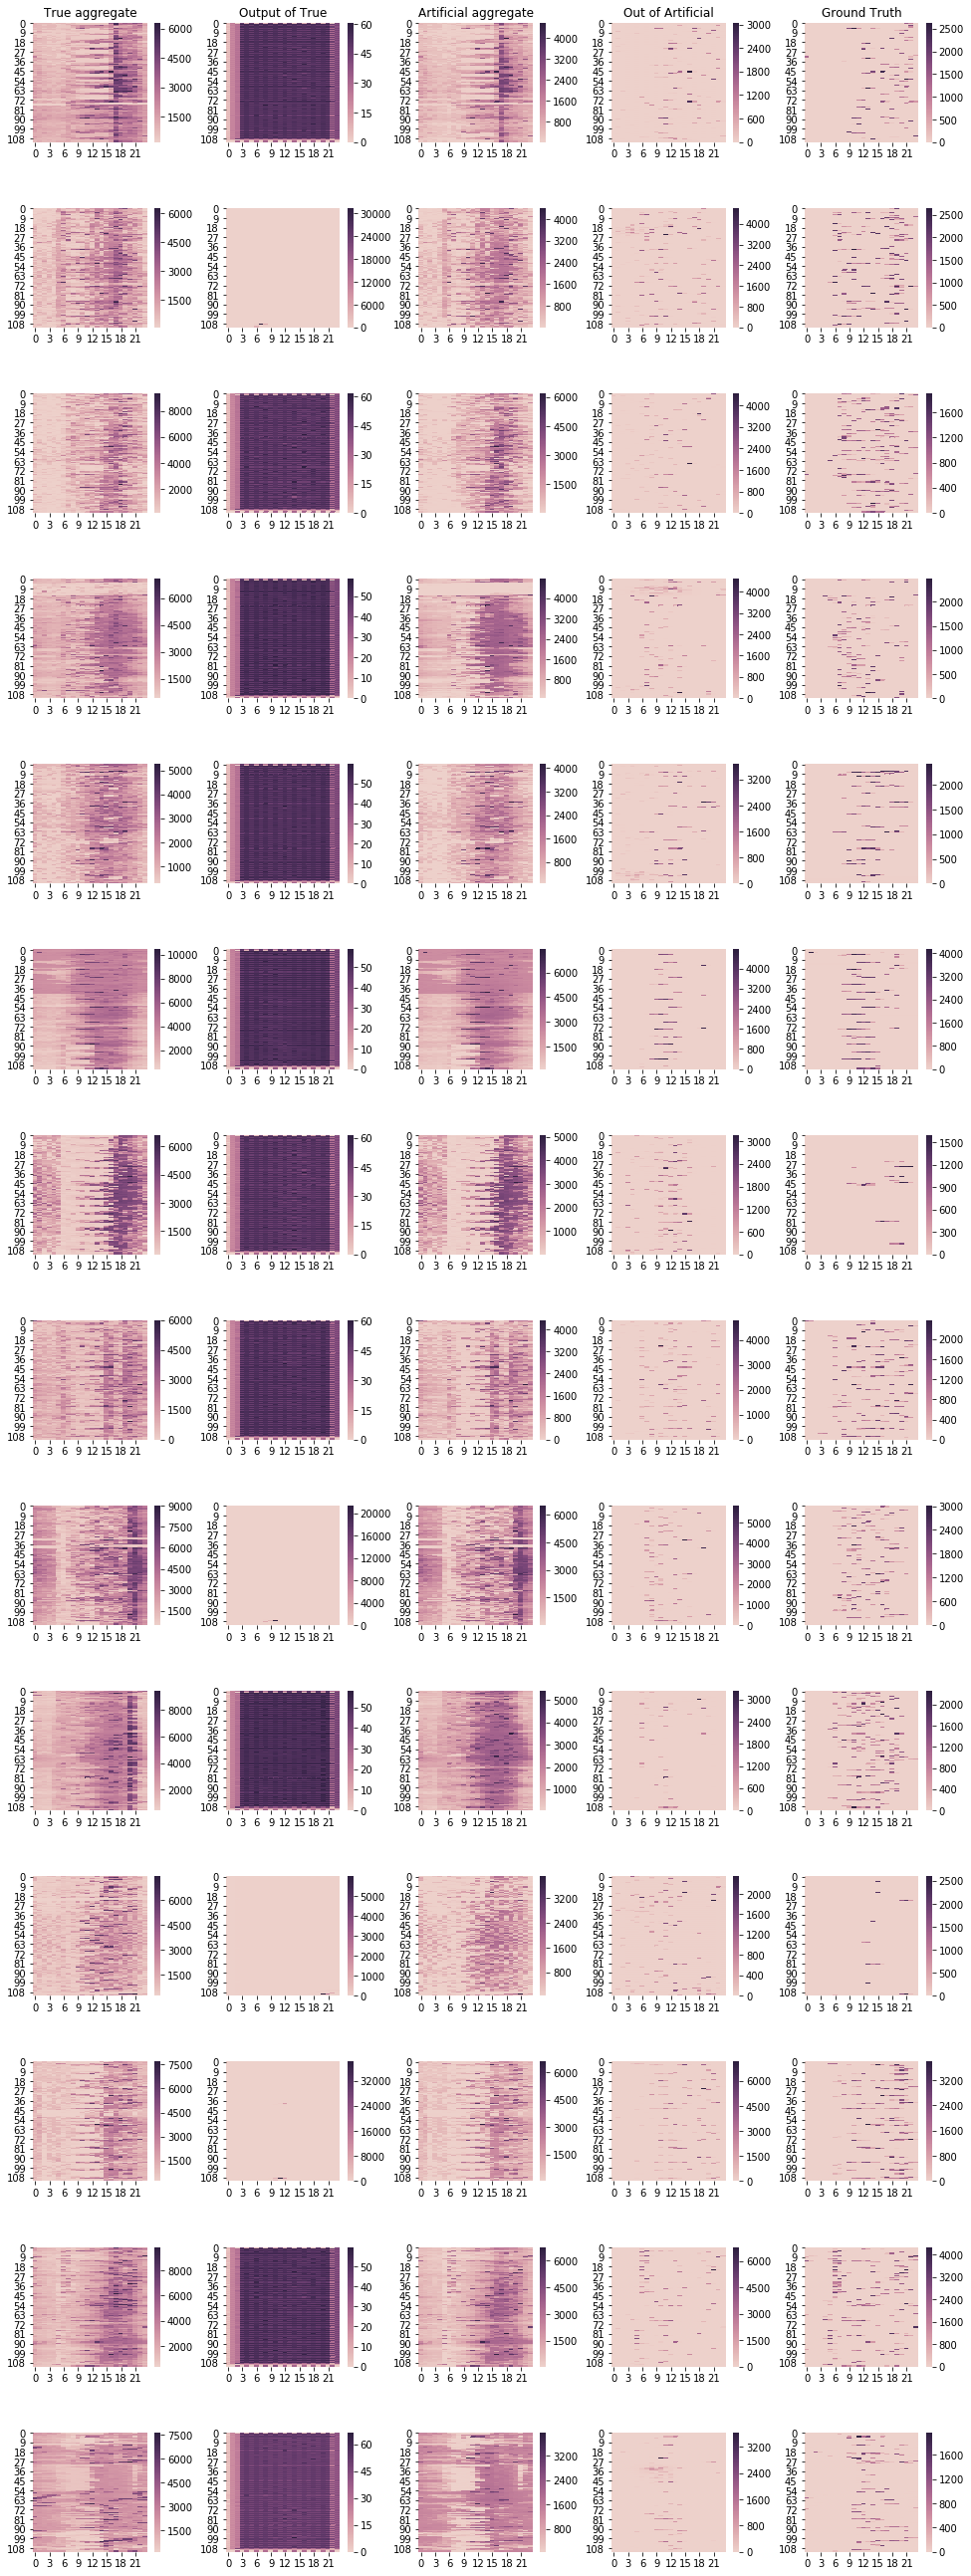

In [257]:
num_homes = t_test_aggregate.shape[0]
ncols = 5
fig, axes = plt.subplots(ncols=ncols, nrows=num_homes, figsize=(ncols*3, num_homes*3))
ax = axes.flatten()
# homes = [0, 4, 8, 12]
appliance = 'dr'
# fold_num = 0

for i in range(num_homes):
    
    
    # plot the true aggregate input
    sns.heatmap(t_test_aggregate[i][0], cmap=cmap, ax=ax[i*ncols])
    
    # plot the result of true aggregate input
    sns.heatmap(t_test_fold[ORDER.index(appliance)].reshape(-1, 112, 24)[i], cmap=cmap, ax=ax[i*ncols+1])
    
    # plot the artificial aggregate input
    sns.heatmap(a_test_aggregate[i][0], cmap=cmap, ax=ax[i*ncols+2])
    
    # plot the result of artificial aggregate input
    sns.heatmap(a_test_fold[ORDER.index(appliance)].reshape(-1, 112, 24)[i], cmap=cmap, ax=ax[i*ncols+3])
    
    # plot the ground truth
    sns.heatmap(test_gt_fold[ORDER.index(appliance)].reshape(-1, 112, 24)[i], cmap=cmap, ax=ax[i*ncols+4])
ax[0].set_title('True aggregate')
ax[1].set_title('Output of True')
ax[2].set_title('Artificial aggregate')
ax[3].set_title('Out of Artificial')
ax[4].set_title('Ground Truth')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.55,wspace=0.35)

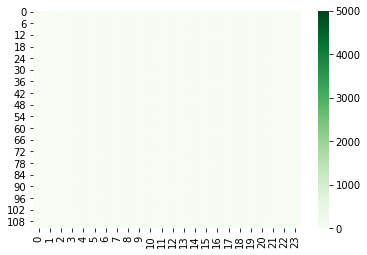

In [76]:
sns.heatmap(t_test_fold[4].reshape(-1, 112, 24)[0], cmap='Greens', vmin=0, vmax=5000)

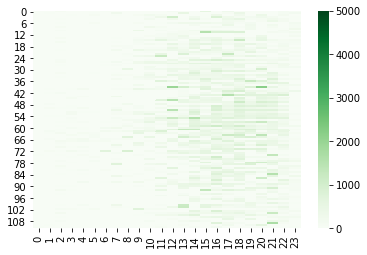

In [74]:
sns.heatmap(a_test_fold[4].reshape(-1, 112, 24)[0], cmap='Greens', vmin=0, vmax=5000)

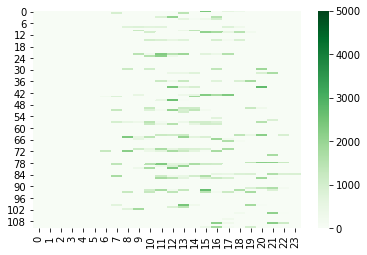

In [75]:
sns.heatmap(test_gt_fold[4].reshape(-1, 112,24)[0], cmap='Greens', vmin=0, vmax=5000)